In [1]:
def get_color_histogram(img, n_bins=32, bins_range=(0, 256)):
    red_hist = np.histogram(img[:,:,0], bins=n_bins, range=bins_range)
    green_hist = np.histogram(img[:,:,1], bins=n_bins, range=bins_range)
    blue_hist = np.histogram(img[:,:,2], bins=n_bins, range=bins_range)
    bin_edges = red_hist[1]
    bin_centers = (bin_edges[1:] + bin_edges[0:len(bin_edges)-1])/2
    hist_features = np.concatenate((red_hist[0], 
                                    green_hist[0], 
                                    blue_hist[0]))
    return red_hist, green_hist, blue_hist, bin_centers, hist_features

def get_3d_color_plot(pixels, colors_rgb,
                      axis_labels=list("RGB"),
                      axis_limits=[(0, 255), (0, 255), (0, 255)]):
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)  
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')
    return ax

def get_bin_spatial(img, color_space='RGB', size=(32, 32)):
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    features = cv2.resize(feature_image, size).ravel() 
    return features

def get_gradient_features(img, sobel_kernel=9, mag_threshold=(60, 255)):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    gradmag = np.sqrt(sobel_x**2 + sobel_y**2)
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_threshold[0]) & 
                  (gradmag <= mag_threshold[1])] = 1
    return binary_output

def get_hog_features(img, 
                     orientation=9, 
                     pixels_per_cell=(8,8), 
                     cells_per_block=(2,2), 
                     visualization=False, 
                     feature_vector=True):
    if visualization == True:
        features, hog_image = hog(img, orientations=orientation, 
                                  pixels_per_cell=pixels_per_cell,
                                  cells_per_block=cells_per_block, 
                                  transform_sqrt=False,
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:
        features = hog(img, orientations=orientation, 
                       pixels_per_cell=pixels_per_cell,
                       cells_per_block=cells_per_block, 
                       transform_sqrt=False,
                       visualise=False, feature_vector=feature_vector) 
        return features
    
def extract_features(images, color_space='RGB', 
                     spatial_size=(32,32), 
                     hist_bins=32, hist_range=(0,256),
                     orientations=9, pixels_per_cell=(8,8),
                     cells_per_block=(2,2), hog_channel=0,
                     spatial_feat=True, hist_feat=True, hog_feat=True):
    features = []
    for file in tqdm(images):
        file_features = []
        img = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(img)      
        
        if spatial_feat == True:
            spatial_features = get_bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            red_hist, green_hist, blue_hist, bin_centers, hist_features = get_color_histogram(feature_image, n_bins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                                         orientations, pixels_per_cell, 
                                                         cells_per_block, visualization=False,
                                                         feature_vector=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], 
                                                orientations, pixels_per_cell,
                                                cells_per_block, visualization=False,
                                                feature_vector=True)
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))      
    return features

In [4]:
#load data
import glob
from random import shuffle

cars = glob.glob('x:/XCar/detection_data/vehicles/**/*.png', recursive=True)
notcars = glob.glob('x:/XCar/detection_data/non-vehicles/**/*.png', recursive=True)

print('len(cars)', len(cars))
print('len(notcars)', len(notcars))
print(cars[1])
    
print(cars[0:4])

shuffle(cars)
shuffle(notcars)
print("shuffled")

len(cars) 8792
len(notcars) 8968
x:/XCar/detection_data/vehicles\GTI_Far\image0001.png
['x:/XCar/detection_data/vehicles\\GTI_Far\\image0000.png', 'x:/XCar/detection_data/vehicles\\GTI_Far\\image0001.png', 'x:/XCar/detection_data/vehicles\\GTI_Far\\image0002.png', 'x:/XCar/detection_data/vehicles\\GTI_Far\\image0003.png']
shuffled


100%|██████████| 8968/8968 [03:20<00:00, 44.69it/s]


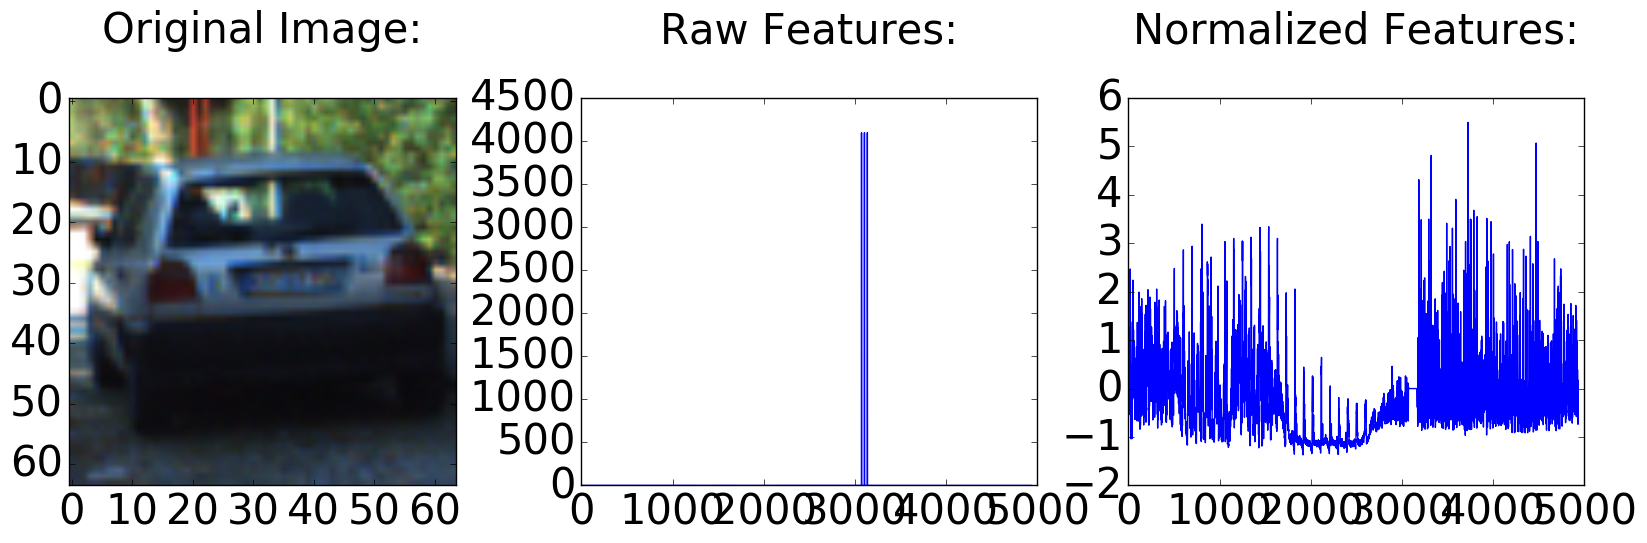

In [ ]:
import numpy as np

import cv2

import matplotlib
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D

from skimage.feature import hog

from sklearn.preprocessing import StandardScaler

# from sklearn.model_selection import train_test_split

from sklearn.svm import LinearSVC

from scipy.ndimage.measurements import label

import pickle
import os

import time

import math

from tqdm import tqdm

veh_features = extract_features(cars, spatial_feat=True, hist_feat=True)
not_veh_features = extract_features(notcars, spatial_feat=True, hist_feat=True)

if len(veh_features) > 0:
    X = np.vstack((veh_features, not_veh_features)).astype(np.float64)
    X_scaler = StandardScaler().fit(X)
    scaled_X = X_scaler.transform(X)
    
    f = plt.figure(figsize=(20, 5))
    matplotlib.rc('xtick', labelsize=30) 
    matplotlib.rc('ytick', labelsize=30)
    
    car_id = np.random.randint(0, len(cars))
    
    plt.subplot(1, 3, 1)
    plt.imshow(mpimg.imread(cars[car_id]))
    plt.title('Original Image:\n', fontsize=30)
    plt.subplot(1, 3, 2)
    plt.plot(X[car_id])
    plt.title('Raw Features:\n', fontsize=30)
    plt.subplot(1, 3, 3)
    plt.plot(scaled_X[car_id])
    plt.title('Normalized Features:\n', fontsize=30)
    plt.savefig('output_images/color_classification.png')

else:
    print('Returned empty feature vectors.')

In [ ]:
y = np.hstack((np.ones(len(veh_features)), np.zeros(len(not_veh_features))))

X = np.vstack((veh_features, not_veh_features)).astype(np.float64)
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)



print ("scaled_X.shape:",scaled_X.shape)
print ("y.shape:",y.shape)

rand_state = np.random.randint(0, 10)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2,random_state=rand_state)

In [ ]:
#train svc
#LinearSVC model
svc = LinearSVC(C=0.01)
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'seconds to train SVC.')

In [ ]:
print('Test Accuracy: {0:0.4f}%'.format(svc.score(X_test, y_test)*100))
print('  Predictions:', svc.predict(X_test[0:10]))
print('       Labels:', y_test[0:10])

In [ ]:
#classifier with hog features

veh_features = extract_features(cars, hog_feat=True)
not_veh_features = extract_features(notcars, hog_feat=True)

if len(veh_features) > 0:
    X = np.vstack((veh_features, not_veh_features)).astype(np.float64)
    X_scaler = StandardScaler().fit(X)
    scaled_X = X_scaler.transform(X)
    
    f = plt.figure(figsize=(20, 5))
    matplotlib.rc('xtick', labelsize=30) 
    matplotlib.rc('ytick', labelsize=30)

    plt.subplot(1, 3, 1)
    plt.imshow(mpimg.imread(cars[car_id]))
    plt.title('Original Image:\n', fontsize=30)
    plt.subplot(1, 3, 2)
    plt.plot(X[car_id])
    plt.title('Raw Features:\n', fontsize=30)
    plt.subplot(1, 3, 3)
    plt.plot(scaled_X[car_id])
    plt.title('Normalized Features:\n', fontsize=30)
    plt.savefig('output_images/hog_classification.png')

else:
    print('Returned empty feature vectors.')

In [ ]:
y = np.hstack((np.ones(len(veh_features)), np.zeros(len(not_veh_features))))

X = np.vstack((veh_features, not_veh_features)).astype(np.float64)
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)
rand_state = np.random.randint(0, 10)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2,random_state=rand_state)
svc = LinearSVC(C=0.01)
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'seconds to train SVC.')



In [ ]:
print('Test Accuracy: {0:0.4f}%'.format(svc.score(X_test, y_test)*100))
t = time.time()
print('  Predictions:', svc.predict(X_test[0:10]))
print('       Labels:', y_test[0:10])
t2 = time.time()
print(round(t2-t, 5), 'seconds to predict 10 labels with SVC.')

## Detection

In [ ]:
def draw_boxes(img, bboxes, color=(0,0,255), thickness=6):
    img_copy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(img_copy, bbox[0], bbox[1], 
                      color, thickness)
    return img_copy

def sliding_windows(img, x_start_stop=[None,None], 
                    y_start_stop=[None,None], xy_window=(64,64),
                    xy_overlap=(0.5,0.5)):
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = int(img.shape[0]*0.45)
    if y_start_stop[1] == None:
        y_start_stop[1] = int(img.shape[0]*0.9)
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    window_list = []
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            window_list.append(((startx, starty), (endx, endy)))
    return window_list


In [ ]:
test_img = mpimg.imread('test_images/test4.jpg')

windows =  sliding_windows(test_img)

window_img = draw_boxes(test_img, windows)
plt.imshow(window_img);
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15)
plt.title('Sliding Windows Technique:\n', fontsize=15);
plt.savefig('output_images/sliding_windows_test4.png')